In [1]:
import requests
from datetime import datetime
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import norm
import json
import matplotlib.pyplot as plt

In [2]:
api_key = "LULKG4NIIZEJI6D2"
api_key2 = "YPOLRZMHBE5X9RKF"
query_date = "2017-11-15"
symbol = "SPY"

In [4]:
url = f'https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol={symbol}&date={query_date}&apikey={api_key}'

In [12]:
query_date_range = pd.date_range(start='2024-01-15', end='2024-01-31', freq='B')

In [13]:
data = []
for query_date in query_date_range:
    query_date = query_date.strftime('%Y-%m-%d')
    url = f'https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol={symbol}&date={query_date}&apikey={api_key}'
    response = requests.get(url)
    d = response.json()
    if d['message']=='success':
        data.append(d['data'])

KeyError: 'message'

In [7]:
for query_date in query_date_range:
    query_date = query_date.strftime('%Y-%m-%d')
    url = f'https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol={symbol}&date={query_date}&apikey={api_key2}'
    print(url)

https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol=SPY&date=2024-01-15&apikey=YPOLRZMHBE5X9RKF
https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol=SPY&date=2024-01-16&apikey=YPOLRZMHBE5X9RKF
https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol=SPY&date=2024-01-17&apikey=YPOLRZMHBE5X9RKF
https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol=SPY&date=2024-01-18&apikey=YPOLRZMHBE5X9RKF
https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol=SPY&date=2024-01-19&apikey=YPOLRZMHBE5X9RKF
https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol=SPY&date=2024-01-22&apikey=YPOLRZMHBE5X9RKF
https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol=SPY&date=2024-01-23&apikey=YPOLRZMHBE5X9RKF
https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol=SPY&date=2024-01-24&apikey=YPOLRZMHBE5X9RKF
https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol=SPY&date=2024-01-25&apikey=

In [7]:
# load data from file
with open('data.json', 'r') as f:
    data = json.load(f)

In [8]:
data_ = []
for d in data:
    for _ in d['data']:
        data_.append(_)
    break # taking 1 day data

In [9]:
data_, len(data_)

([{'contractID': 'SPY171101C00220000',
   'symbol': 'SPY',
   'expiration': '2017-11-01',
   'strike': '220.00',
   'type': 'call',
   'last': '0.00',
   'mark': '37.43',
   'bid': '37.24',
   'bid_size': '250',
   'ask': '37.62',
   'ask_size': '250',
   'volume': '0',
   'open_interest': '0',
   'date': '2017-11-01',
   'implied_volatility': '1.16842',
   'delta': '1.00000',
   'gamma': '0.00000',
   'theta': '-0.02552',
   'vega': '0.00000',
   'rho': '0.00603'},
  {'contractID': 'SPY171101P00220000',
   'symbol': 'SPY',
   'expiration': '2017-11-01',
   'strike': '220.00',
   'type': 'put',
   'last': '0.01',
   'mark': '0.01',
   'bid': '0.00',
   'bid_size': '0',
   'ask': '0.01',
   'ask_size': '2846',
   'volume': '0',
   'open_interest': '48672',
   'date': '2017-11-01',
   'implied_volatility': '1.07209',
   'delta': '-0.00231',
   'gamma': '0.00050',
   'theta': '-0.19029',
   'vega': '0.00097',
   'rho': '-0.00002'},
  {'contractID': 'SPY171101C00225000',
   'symbol': 'SPY'

In [10]:
data = data_

In [11]:
ttes = []
current_date = datetime.strptime(query_date, '%Y-%m-%d')
for option in data:
    expiration_date = datetime.strptime(option['expiration'], '%Y-%m-%d')
    tte_days = (expiration_date - current_date).days
    ttes.append(tte_days)

In [12]:
unique_ttes = np.unique(ttes)

In [13]:
# print("Unique TTEs (in days) and their frequencies:")
# for tte in unique_ttes:
#     print(f"{tte} days: {ttes.count(tte)} instances")

In [43]:
df = pd.DataFrame()

In [44]:
for option in data:
    expiration_date = datetime.strptime(option['expiration'], '%Y-%m-%d')
    current_date = datetime.strptime(option['date'], '%Y-%m-%d')
    tte_days = (expiration_date - current_date).days
    if tte_days <10:
        continue
    tau = tte_days / 365.0
    delta = abs(float(option['delta']))
    sigma = float(option['implied_volatility'])/100.0
    N_inv = norm.ppf(delta)
    m = 0.5*sigma**2*tau + N_inv*sigma*np.sqrt(tau)
    # create dataset of iv, tau, m
    df = pd.concat([df, pd.DataFrame({'iv': [sigma*100], 'tau': [tau], 'm': [m], 'delta': [delta], 'N_inv': [N_inv]})])

In [53]:
df.head()

,tau,m,iv,delta,N_inv
0,0.038356,-0.001369,0.29071,0.00808,-2.405282
1,0.038356,-0.001145,0.24864,0.00934,-2.351856
2,0.038356,-0.000928,0.22349,0.01700,-2.120072
3,0.038356,-0.000715,0.18949,0.02705,-1.926035
4,0.038356,-0.000694,0.18782,0.02963,-1.886259


In [54]:
# remove index
df.reset_index(drop=True, inplace=True)

In [55]:
delta = df['delta']
tau = df['tau']
iv = df['iv']
print(delta.shape, tau.shape, iv.shape)

(3709,) (3709,) (3709,)


In [56]:
print(df['iv'].describe())

count    3709.000000
mean        0.193138
std         0.166297
min         0.060990
25%         0.111750
50%         0.146960
75%         0.220280
max         2.962600
Name: iv, dtype: float64


In [57]:
# drop inf values
df = df.replace([np.inf, -np.inf], np.nan).dropna()

In [58]:
# in df for a given tau and delta, we have multiple iv values
# we need to find the average of iv values for each tau and delta
df = df.groupby(['tau', 'm']).mean().reset_index()
df.head()

,tau,m,iv,delta,N_inv
0,0.038356,-0.001369,0.29071,0.00808,-2.405282
1,0.038356,-0.001145,0.24864,0.00934,-2.351856
2,0.038356,-0.000928,0.22349,0.01700,-2.120072
3,0.038356,-0.000715,0.18949,0.02705,-1.926035
4,0.038356,-0.000694,0.18782,0.02963,-1.886259


In [59]:
from scipy.interpolate import griddata

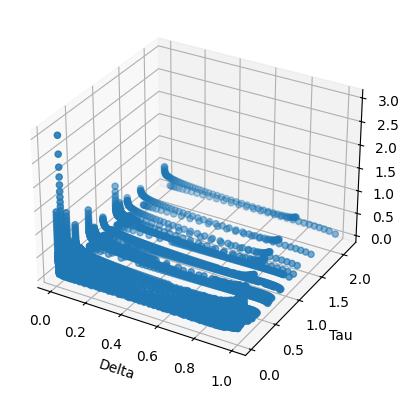

In [60]:
# plot the surface, delta vs tau vs iv
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['delta'], df['tau'], df['iv'])
ax.set_xlabel('Delta')
ax.set_ylabel('Tau')
ax.set_zlabel('IV')
plt.show()

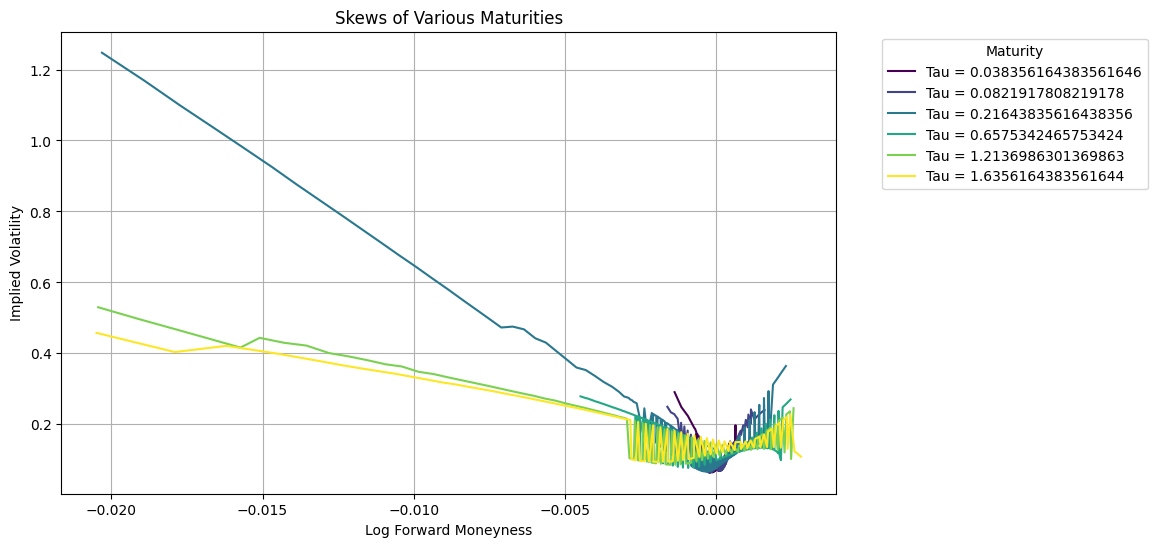

In [61]:
maturities = df['tau'].unique()
# select only 5 maturities - 1st, 6th, 11th, 16th, 21st, 25th
maturities = maturities[[0, 5, 10, 15, 20, 22]]
colors = plt.cm.viridis(np.linspace(0, 1, len(maturities)))  # Color map
plt.figure(figsize=(10, 6))

for maturity, color in zip(maturities, colors):
    subset = df[df['tau'] == maturity]
    plt.plot(subset['m'], subset['iv'], label=f'Tau = {maturity}', color=color)


plt.xlabel('Log Forward Moneyness')
plt.ylabel('Implied Volatility')
plt.title('Skews of Various Maturities')
plt.legend(title='Maturity', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.grid(True)
plt.show()